# Kr NEW Fits

J. A Hernando, C. Herves

April 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Jun  1 13:33:51 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEXT100/Kr/'
runs = 'MC01'

In [7]:
from os import listdir

run = 'MC01'
filenames = listdir(path+str(run))
filenames.sort()
print(len(filenames), filenames[0], filenames[-1])
filenames = [path + str(run) + '/' + ifile for ifile in filenames]

3209 dorothea_10000_kr83m.h5 dorothea_3889_kr83m.h5


In [8]:
kdst = load_dsts(filenames, "DST", "Events")

In [10]:
print(np.min(kdst.X[kdst.X > -1000.]), np.max(kdst.X))
print(np.min(kdst.Y[kdst.Y > -1000.]), np.max(kdst.Y))

-489.82500000000005 489.82500000000005
-489.82499999999993 489.82500000000005


In [12]:
kdst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [13]:
names = ['event', 'time', 'S2e', 'X', 'Y', 'Z', 'DT']
sel   = (kdst.nS1 == 1) & (kdst.nS2 == 1)
kdst = kdst[sel][names]
kdst['R'] = np.sqrt(kdst.X**2 + kdst.Y**2)
kdst.replace(np.nan, 0.)
kdst = kdst.rename(columns = {'S2e' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z', 
                              'DT' : 'dtime', 'R' : 'r'})

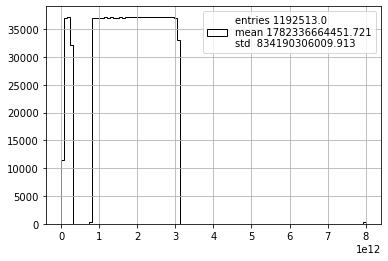

In [14]:
mkdst = kdst
pltext.hist(mkdst.time, 100);

In [15]:
print('size ', len(mkdst))

size  1192513


In [16]:
sels = {}
sels['r']        = ut.in_range(mkdst.r  , (0., 500.))
sels['dtime']    = ut.in_range(mkdst.dtime , (0., 1450.))
sels['energy']   = ut.in_range(mkdst.energy, (0e3, 20e4))
sels['fidutial'] = (sels['r']) & (sels['dtime']) & (sels['energy'])

In [17]:
mkdst.columns

Index(['event', 'time', 'energy', 'x', 'y', 'z', 'dtime', 'r'], dtype='object')

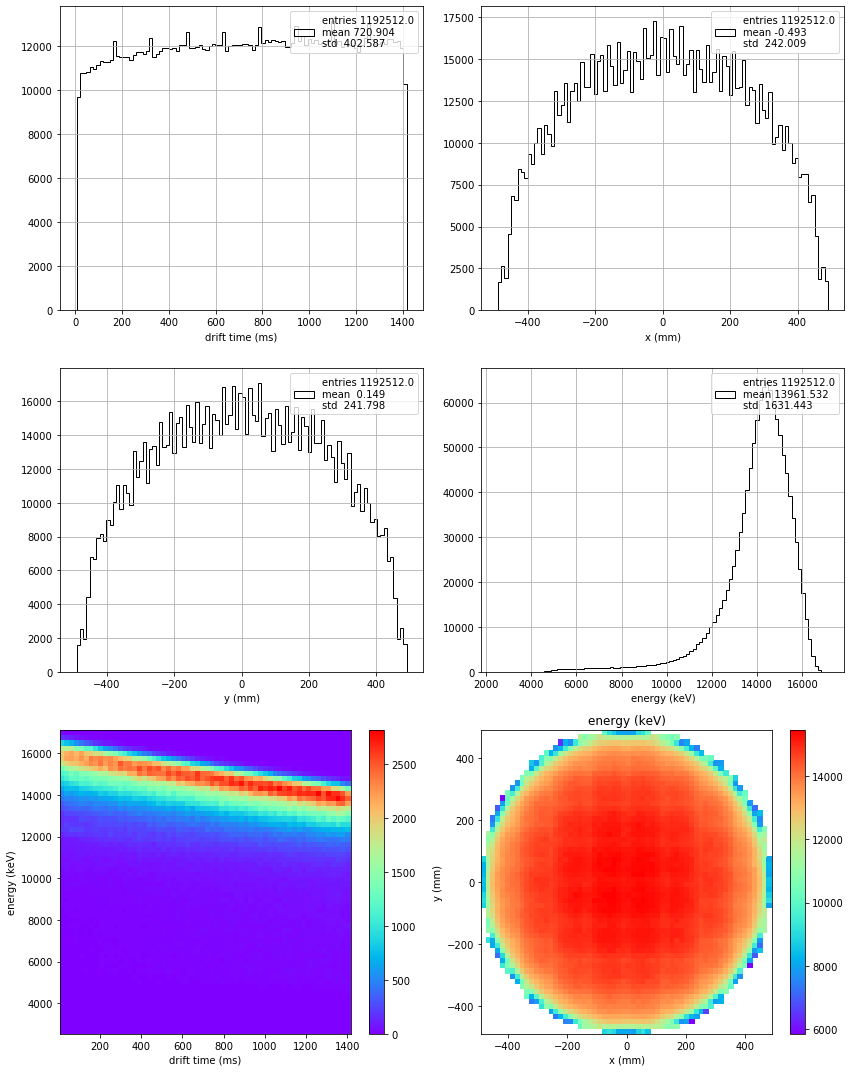

In [18]:
sel = sels['fidutial']
krana.plot_data(mkdst[sel], 60)

In [58]:
vdrift = np.max(mkdst[sel].z/mkdst[sel].dtime)
print('Drift velocity {:6.4f}'.format(vdrift))

Drift velocity 0.8400


## Kr Map

In [66]:
counts_min = 40
pitch = 15.00
xmin  = -489.825
xbins = np.arange(xmin, -xmin + pitch, pitch)
print(len(xbins), xbins)
bins  = (xbins, xbins) 
#bins   = (40, 40) 

67 [-489.825 -474.825 -459.825 -444.825 -429.825 -414.825 -399.825 -384.825
 -369.825 -354.825 -339.825 -324.825 -309.825 -294.825 -279.825 -264.825
 -249.825 -234.825 -219.825 -204.825 -189.825 -174.825 -159.825 -144.825
 -129.825 -114.825  -99.825  -84.825  -69.825  -54.825  -39.825  -24.825
   -9.825    5.175   20.175   35.175   50.175   65.175   80.175   95.175
  110.175  125.175  140.175  155.175  170.175  185.175  200.175  215.175
  230.175  245.175  260.175  275.175  290.175  305.175  320.175  335.175
  350.175  365.175  380.175  395.175  410.175  425.175  440.175  455.175
  470.175  485.175  500.175]


In [67]:
def clean_krmap(coors, dtime, energy):
    sel     = np.ones(len(energy), bool)
    clean   = np.copy(sel)
    done    = False
    while (not done):
        icoors  = [coor[clean] for coor in coors]
        idtime  = dtime[clean]
        iene    = energy[clean]
        krmap, residuals   = krana.krmap(icoors, idtime, iene,
                                         bins = bins, counts_min = counts_min, dt0 = 0.)
        done, usel = krana.accept_residuals(residuals, range = (-5.,5.), 
                                            fun = 'gaus', nsigma = 4., min_sigma = 0.98, plot = True)
        clean[clean == True] = usel
    return krmap, clean

## Clean KrMap

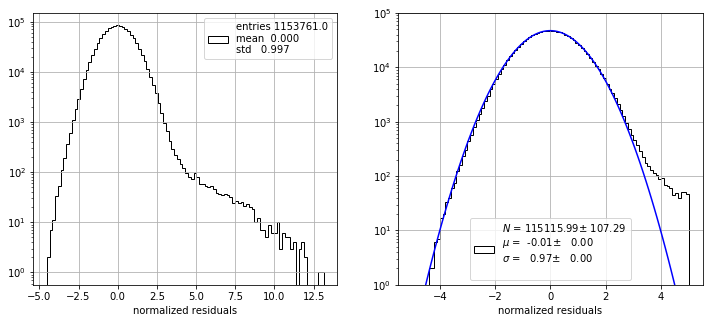

sigma 0.97 done  False  eff 99.76


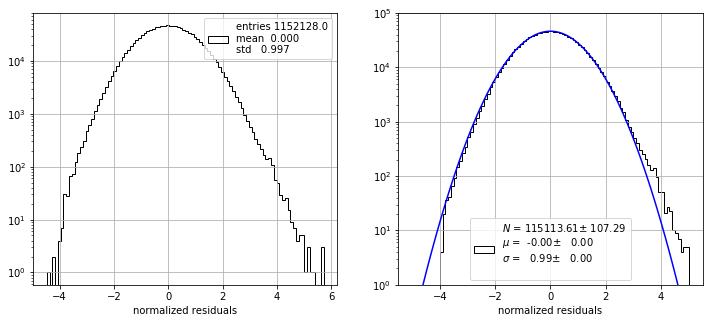

sigma 0.99 done  True  eff 100.00


In [68]:
krmap, usel = clean_krmap(coors, dtime, energy)

In [69]:
clean = np.ones(len(mkdst), bool)
fid   = sels['fidutial']
clean[fid == True] = usel

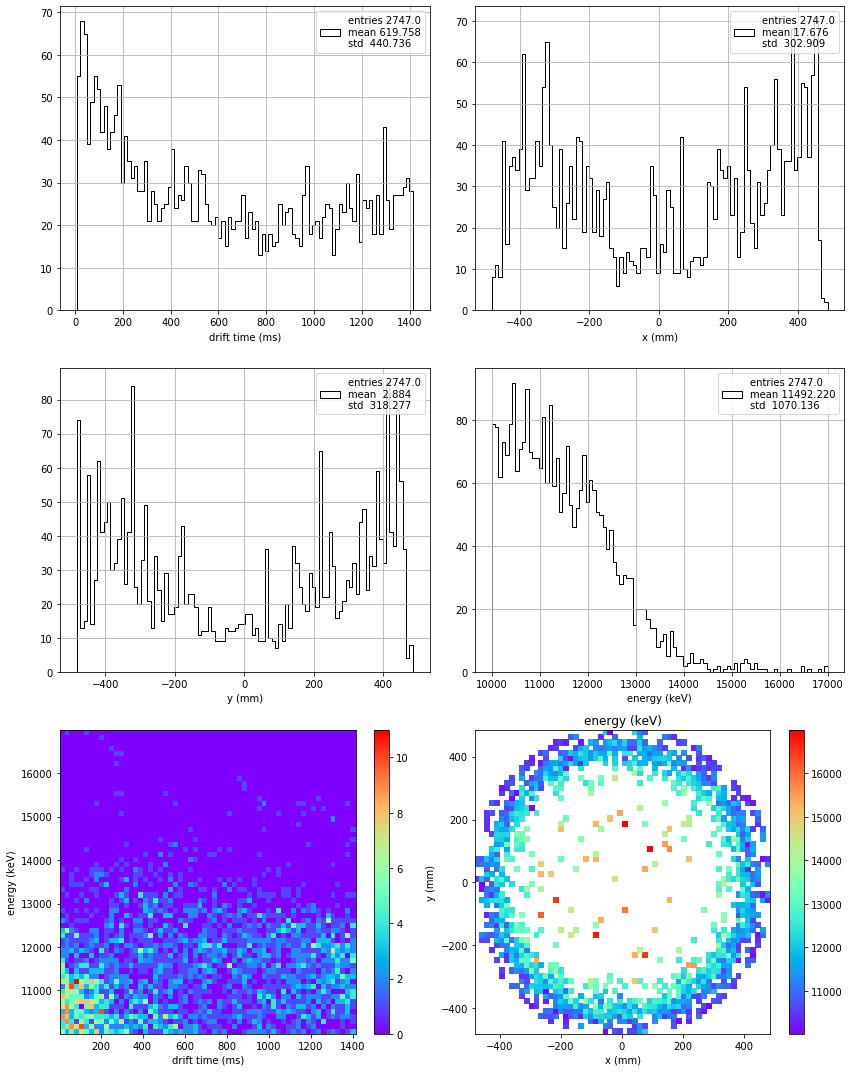

In [70]:
sels['clean'] = clean
krana.plot_data(mkdst[~clean], 60)

## KrMap with fidutual and clean events

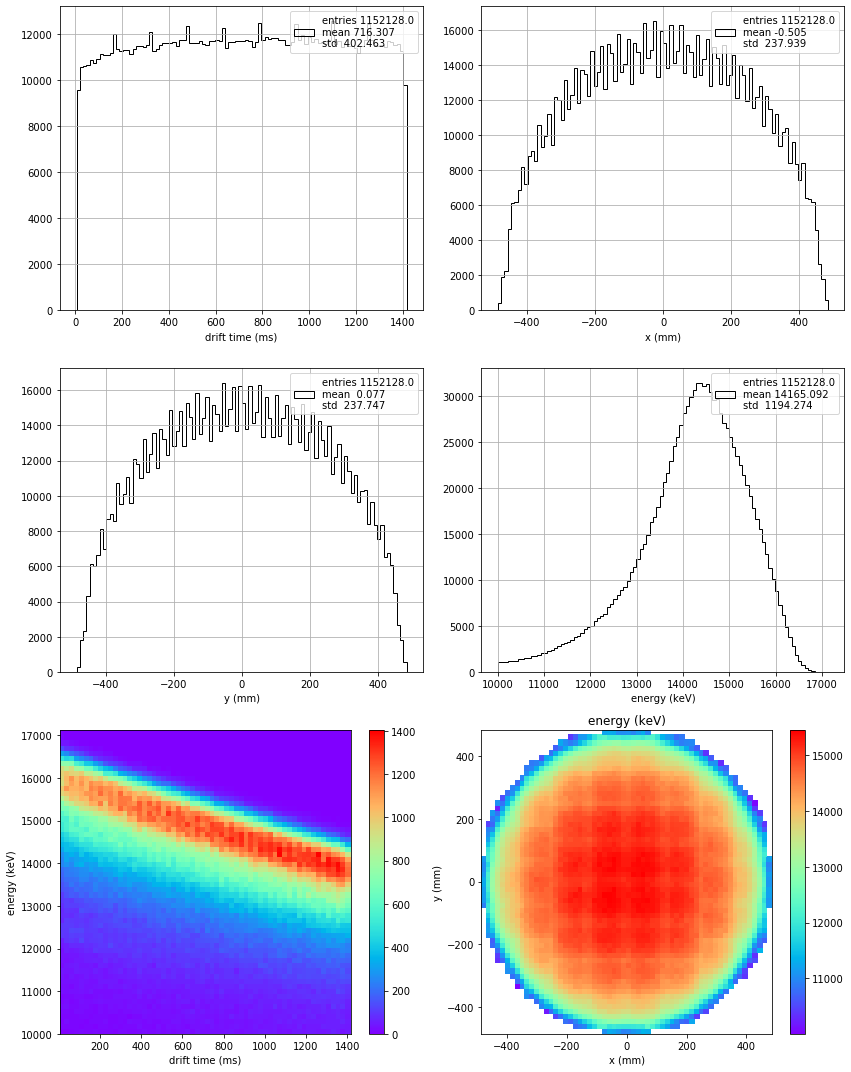

In [71]:
sel = sels['clean'] & sels['fidutial']
krana.plot_data(mkdst[sel], 60)

In [73]:
sel    = sels['clean'] & sels['fidutial'] #& ut.in_range(mkdst.z, (300., 1200.))
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
counts_min = 40
bins   = (xbins, xbins) 
krmap, _  = krana.krmap(coors, dtime, energy, bins = bins, 
                        counts_min = counts_min, dt0 = 0.)

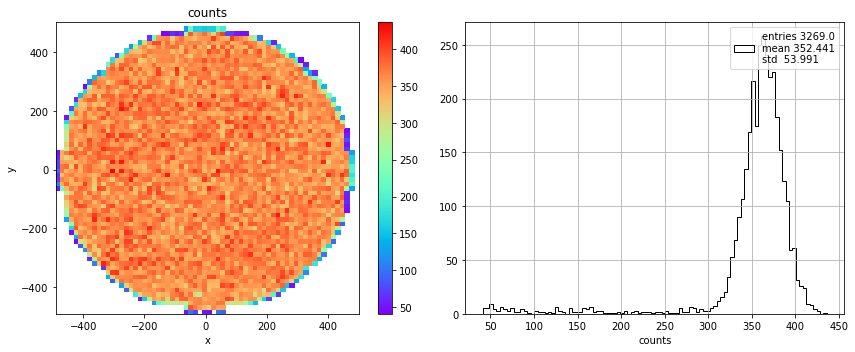

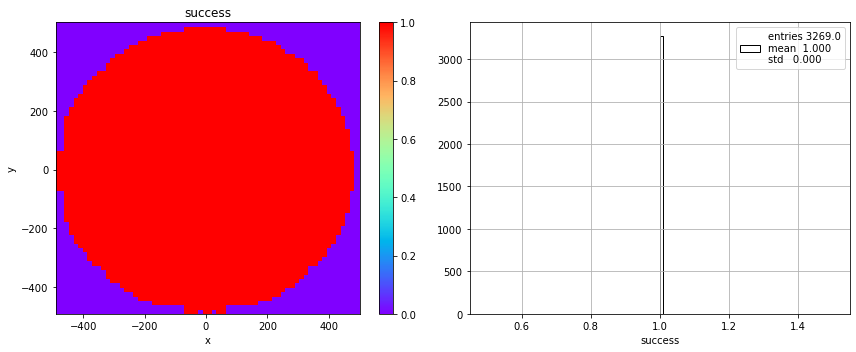

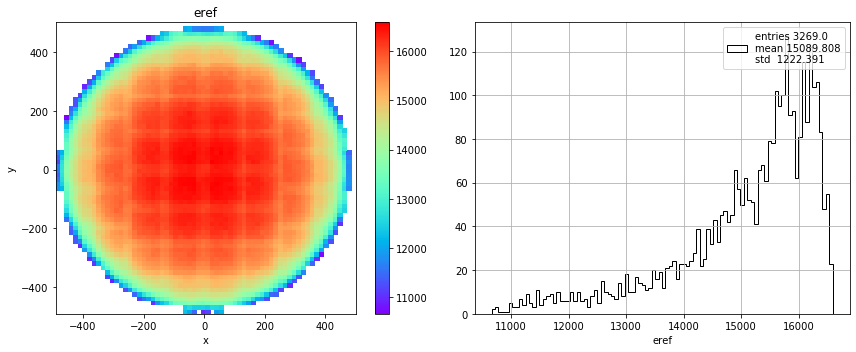

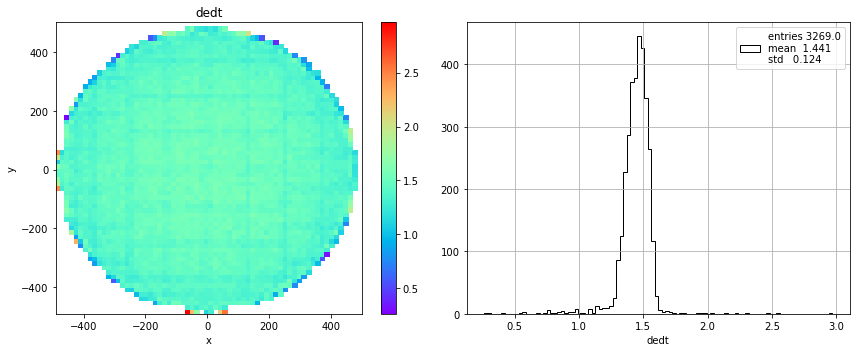

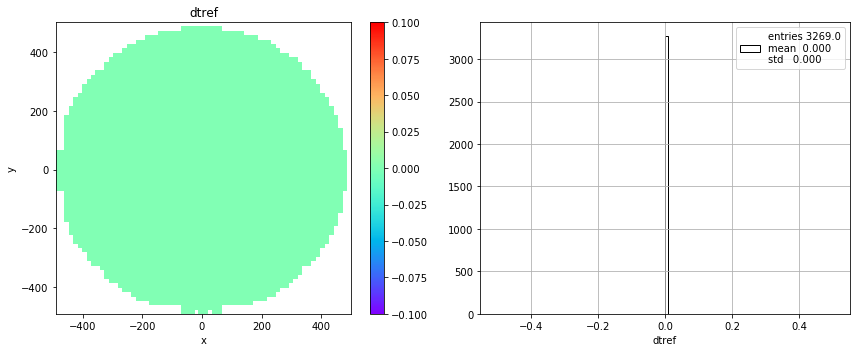

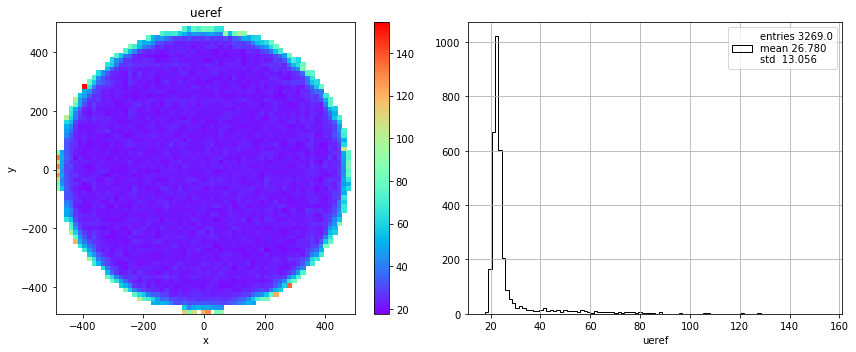

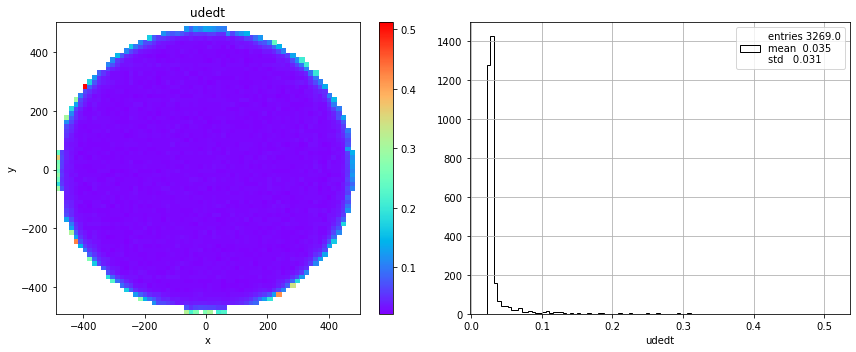

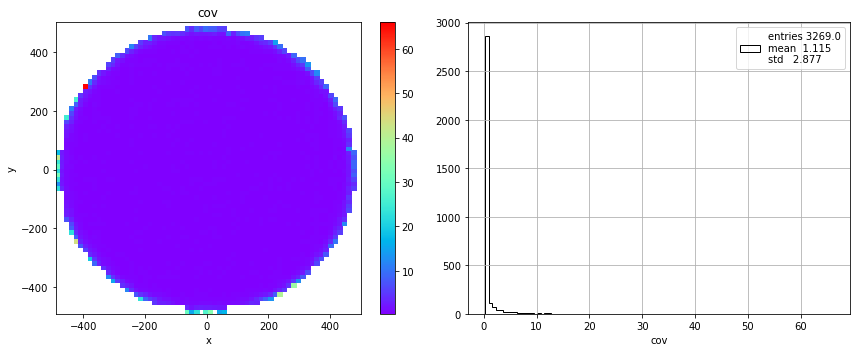

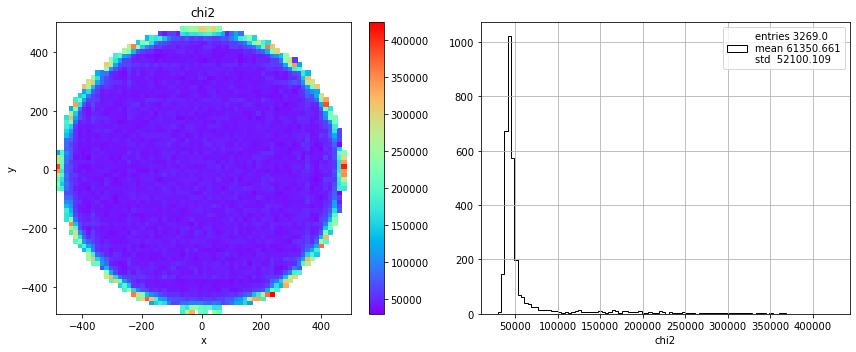

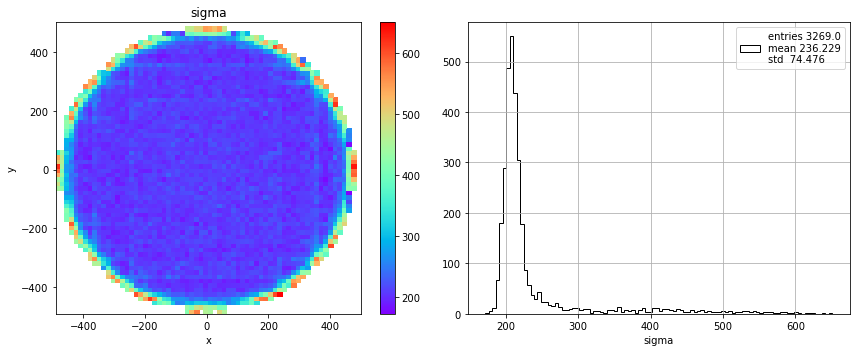

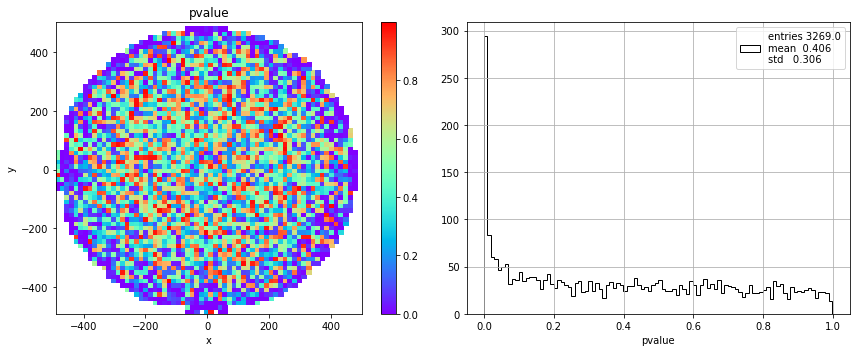

In [74]:
krana.plot_xyvar(krmap.counts , krmap.bin_edges, 'counts' , mask = krmap.counts > 0)
krana.plot_xyvar(krmap.success, krmap.bin_edges, 'success', mask = krmap.success)
krana.plot_xyvar(krmap.eref   , krmap.bin_edges, 'eref'   , mask = krmap.success)
krana.plot_xyvar(krmap.dedt   , krmap.bin_edges, 'dedt'   , mask = krmap.success)
krana.plot_xyvar(krmap.dtref  , krmap.bin_edges, 'dtref'  , mask = krmap.success)
krana.plot_xyvar(krmap.ueref  , krmap.bin_edges, 'ueref'  , mask = krmap.success)
krana.plot_xyvar(krmap.udedt  , krmap.bin_edges, 'udedt'  , mask = krmap.success)
krana.plot_xyvar(krmap.cov    , krmap.bin_edges, 'cov'    , mask = krmap.success)
krana.plot_xyvar(krmap.chi2   , krmap.bin_edges, 'chi2'   , mask = krmap.success)
krana.plot_xyvar(krmap.sigma  , krmap.bin_edges, 'sigma'  , mask = krmap.success)
krana.plot_xyvar(krmap.pvalue , krmap.bin_edges, 'pvalue' , mask = krmap.success)

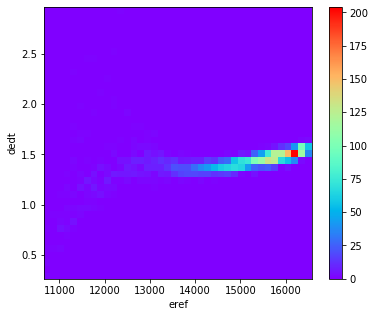

In [75]:
xsel = krmap.success
pltext.canvas(1, 1)
plt.hist2d(krmap.eref[xsel].ravel(), krmap.dedt[xsel].ravel(), (40, 40));
plt.colorbar(); plt.xlabel('eref'); plt.ylabel('dedt');

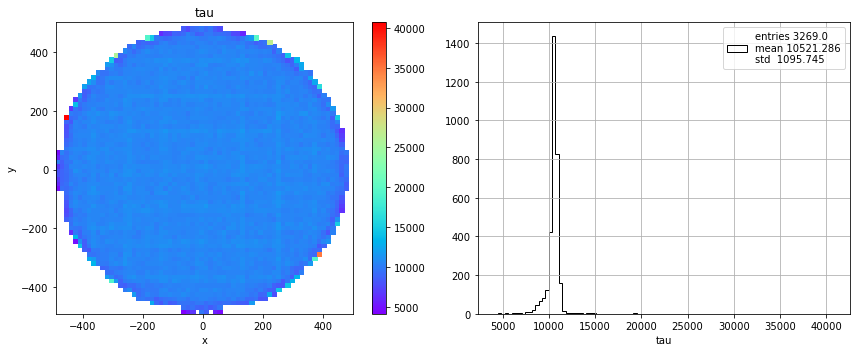

In [76]:
tau  = krmap.eref/krmap.dedt
krana.plot_xyvar(tau , krmap.bin_edges, 'tau' , mask = krmap.success)

## Correction

In [77]:
corr_energy = krana.krmap_scale(coors, dtime, energy, krmap, scale = 41.5)

 Resolution   3.72 % FWHM


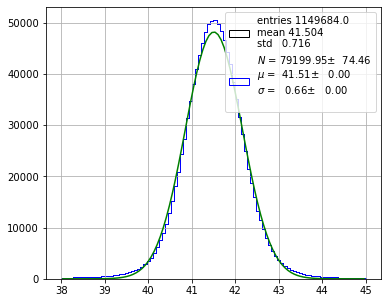

In [78]:
xsel = ~np.isnan(corr_energy)
nbins, erange = 100, (38., 45)
pltext.canvas(1, 1);
pltext.hist(corr_energy[xsel], nbins, erange);
cc = pltext.hfit(corr_energy[xsel], nbins, range = erange, fun = 'gaus');
pars = cc[3]
resolution = 235.5 * pars[2]/pars[1]
print(' Resolution {:6.2f} % FWHM'.format(resolution))

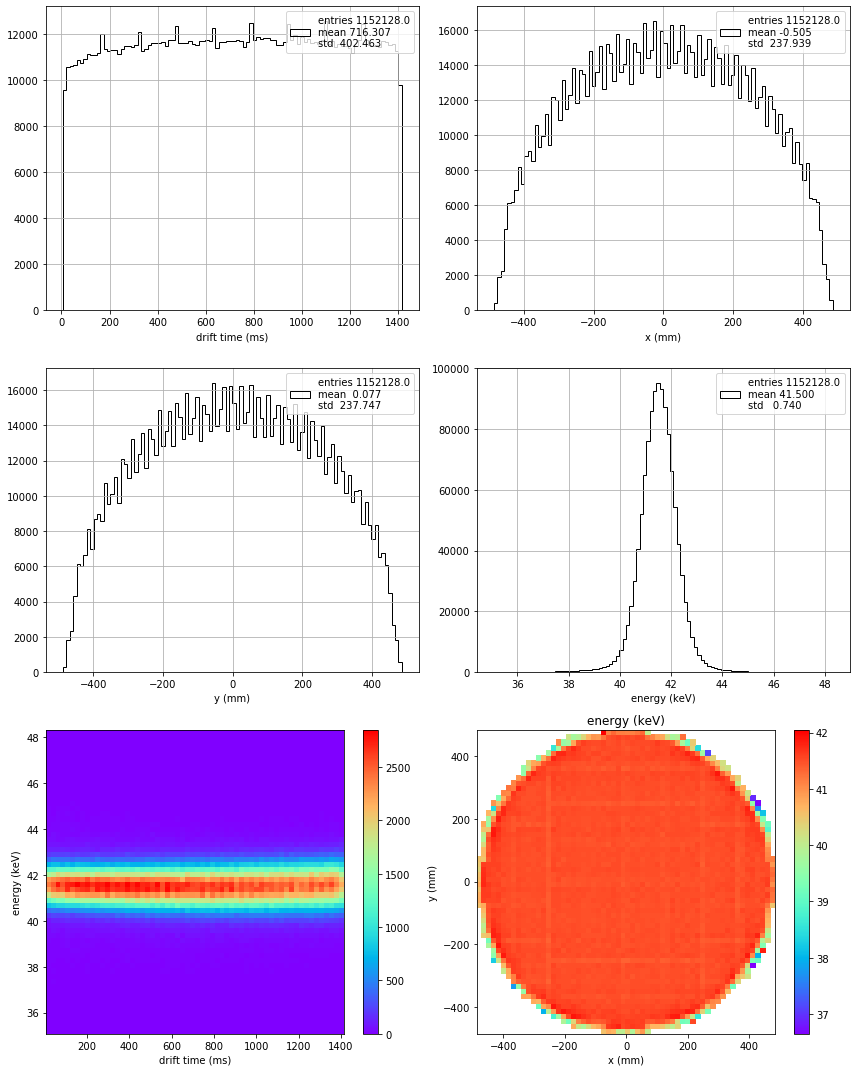

In [79]:
xsel = ~np.isnan(corr_energy)
df = {'x': coors[0][xsel], 'y' : coors[1][xsel], 'dtime': dtime[xsel], 'energy' : corr_energy[xsel]}
df = pd.DataFrame(df)
krana.plot_data(df, bins = 60)

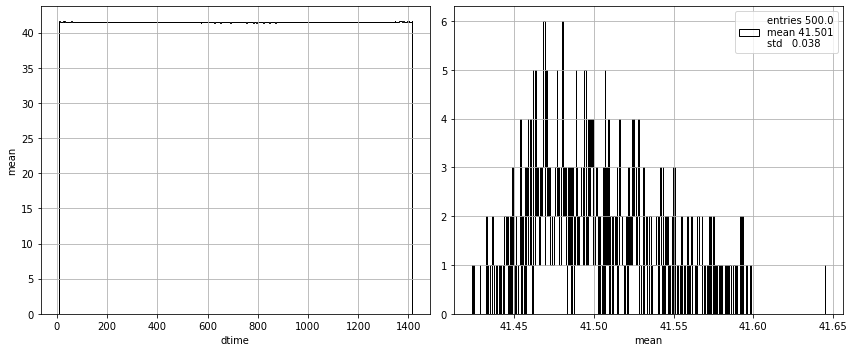

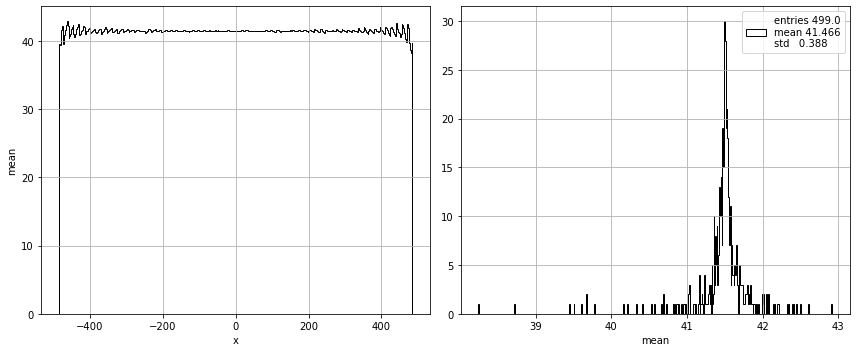

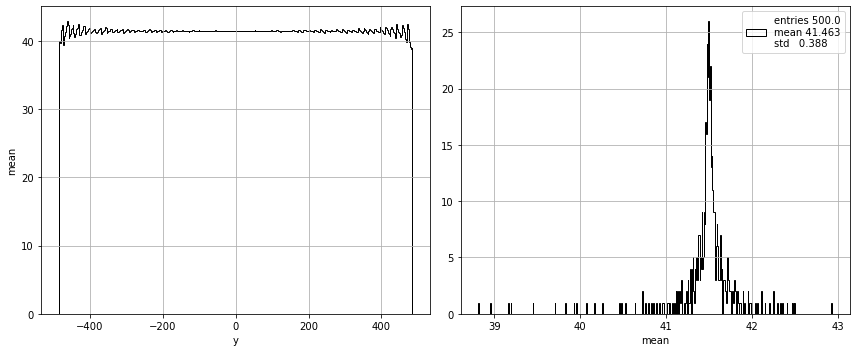

In [80]:
krana.plot_xydt_energy_profiles(df, nbins = 500)

## Store

In [81]:
krana.save(krmap , 'krmap' , 'krmap_NEXT100_MC01.h5');
#prof .save(xyprof, 'xyprof', 'krmap_'+str(run)+'.h5');

## Refine the correction

In [82]:
xmin  = -489.825
xbins = np.arange(xmin, -xmin + pitch, pitch/3.)
print(len(xbins), xbins[1] - xbins[0])
bins  = (xbins, xbins) 

199 [-4.89825e+02 -4.84825e+02 -4.79825e+02 -4.74825e+02 -4.69825e+02
 -4.64825e+02 -4.59825e+02 -4.54825e+02 -4.49825e+02 -4.44825e+02
 -4.39825e+02 -4.34825e+02 -4.29825e+02 -4.24825e+02 -4.19825e+02
 -4.14825e+02 -4.09825e+02 -4.04825e+02 -3.99825e+02 -3.94825e+02
 -3.89825e+02 -3.84825e+02 -3.79825e+02 -3.74825e+02 -3.69825e+02
 -3.64825e+02 -3.59825e+02 -3.54825e+02 -3.49825e+02 -3.44825e+02
 -3.39825e+02 -3.34825e+02 -3.29825e+02 -3.24825e+02 -3.19825e+02
 -3.14825e+02 -3.09825e+02 -3.04825e+02 -2.99825e+02 -2.94825e+02
 -2.89825e+02 -2.84825e+02 -2.79825e+02 -2.74825e+02 -2.69825e+02
 -2.64825e+02 -2.59825e+02 -2.54825e+02 -2.49825e+02 -2.44825e+02
 -2.39825e+02 -2.34825e+02 -2.29825e+02 -2.24825e+02 -2.19825e+02
 -2.14825e+02 -2.09825e+02 -2.04825e+02 -1.99825e+02 -1.94825e+02
 -1.89825e+02 -1.84825e+02 -1.79825e+02 -1.74825e+02 -1.69825e+02
 -1.64825e+02 -1.59825e+02 -1.54825e+02 -1.49825e+02 -1.44825e+02
 -1.39825e+02 -1.34825e+02 -1.29825e+02 -1.24825e+02 -1.19825e+02
 -1.14

In [83]:
xsel   = df.energy > 0.
coors  = df.x[xsel], df.y[xsel]
enes   = df.energy[xsel]
xbins  = ()
xyprof, _  = prof.profile(coors, enes, bins)

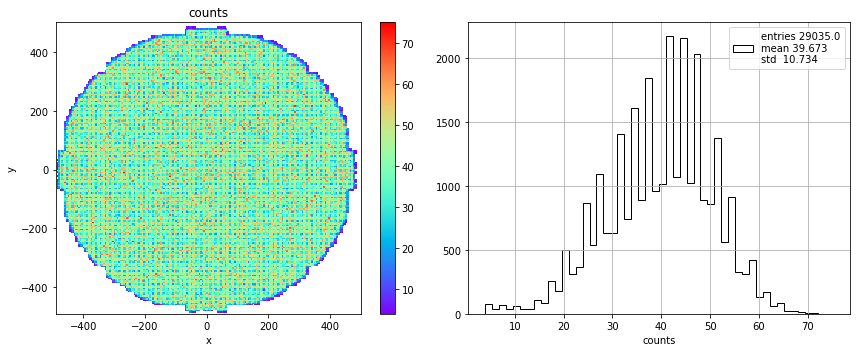

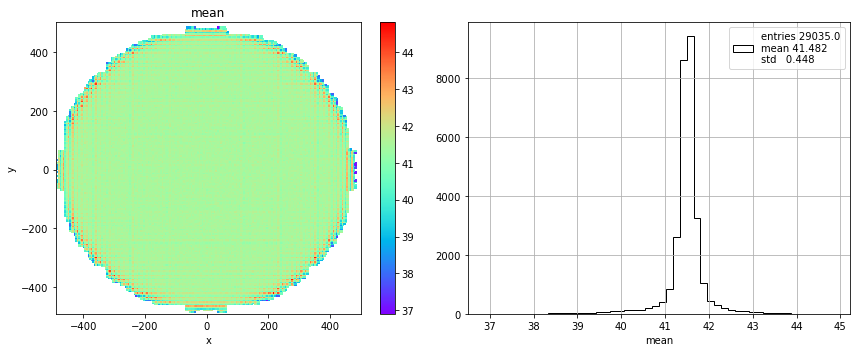

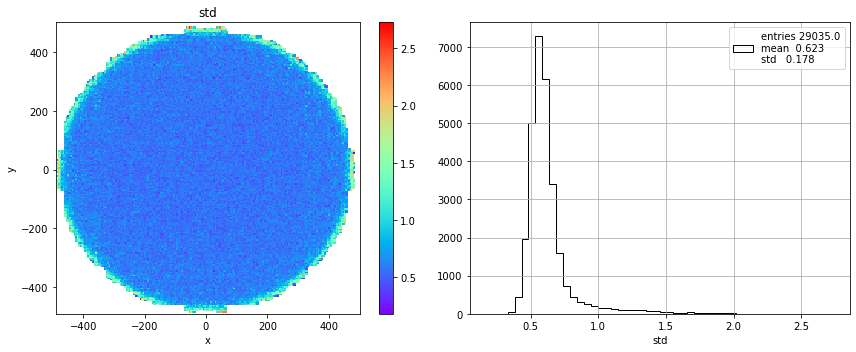

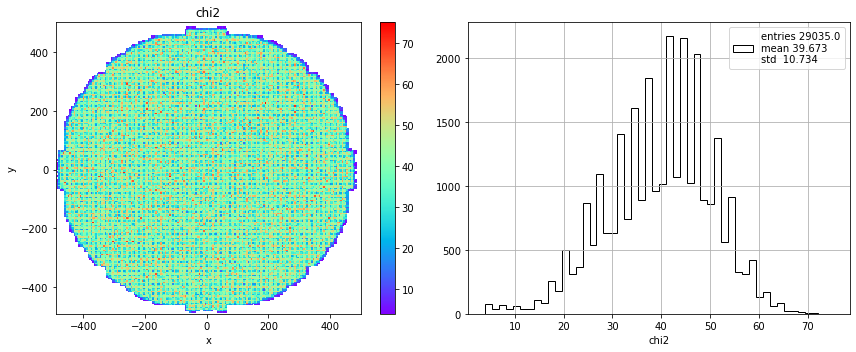

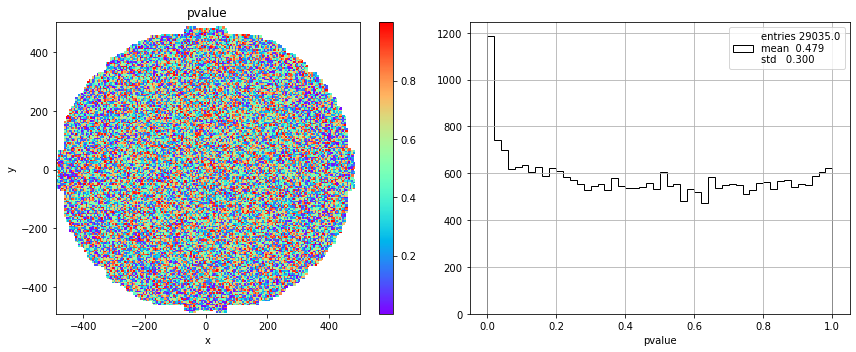

In [84]:
prof.plot_profile(xyprof);

In [85]:
correne = prof.profile_scale(coors, enes, xyprof, 41.5)

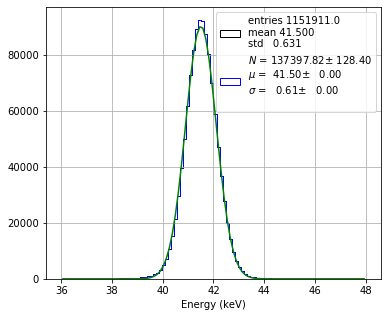

In [86]:
pltext.canvas(1, 1);
pltext.hist(correne, 100, (36, 48));
pltext.hfit(correne, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)');

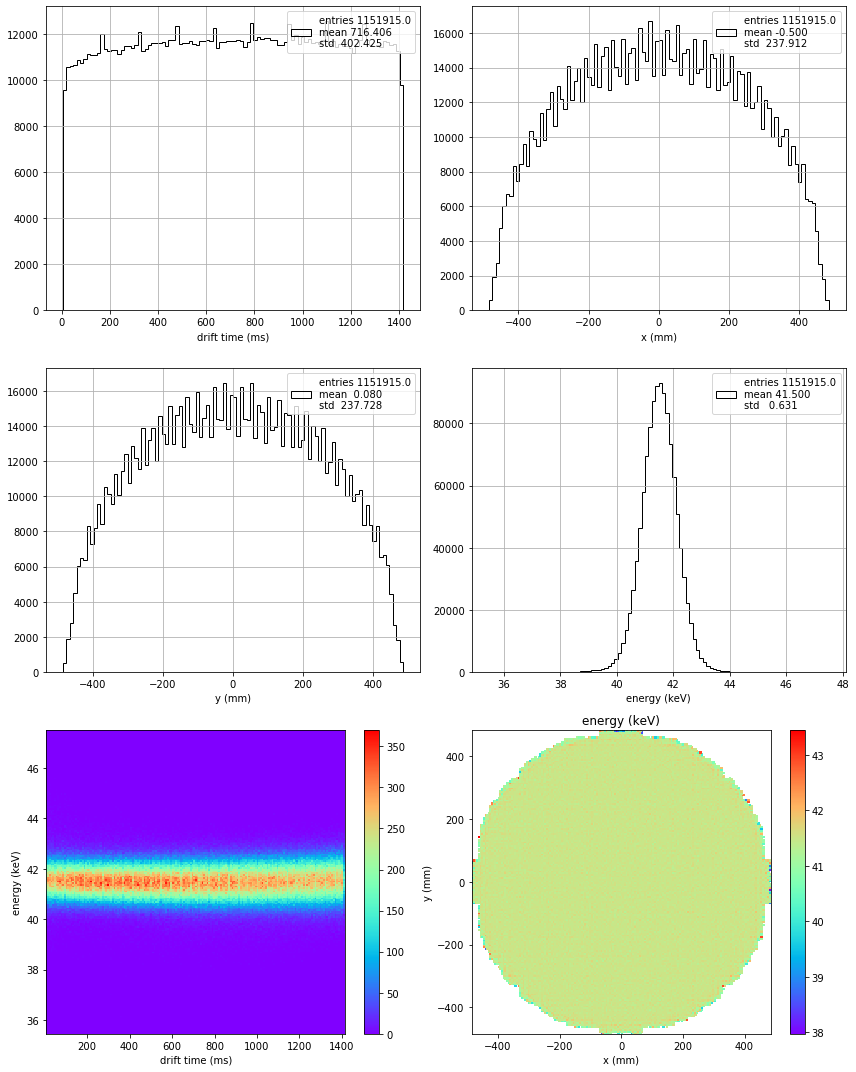

In [89]:
xsel = correne > 9.
xdf = {'x': df.x[xsel], 'y': df.y[xsel], 'dtime': df.dtime[xsel], 'energy': correne[xsel]}
xdf = pd.DataFrame(xdf)
krana.plot_data(xdf, bins = 180)

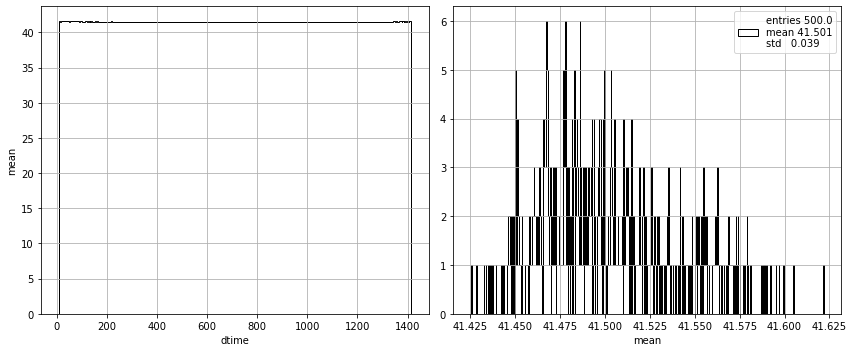

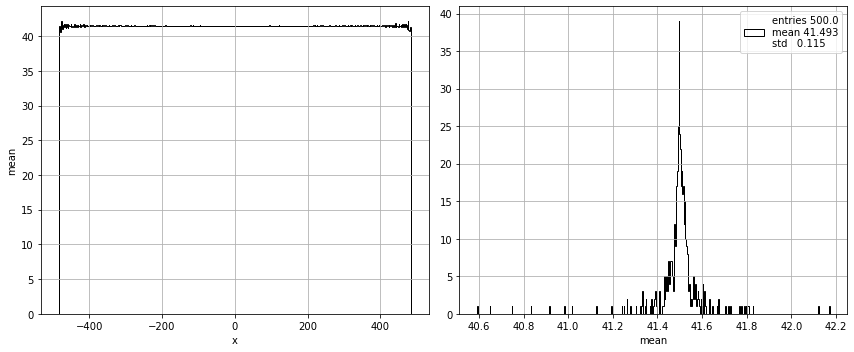

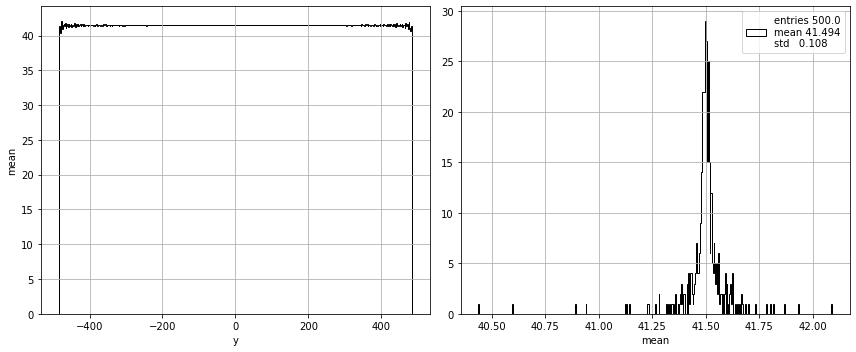

In [90]:
krana.plot_xydt_energy_profiles(xdf, nbins = 500)

## Save

In [91]:
krana.save(krmap , 'krmap' , 'krmap_NEXT100_MC01.h5');
prof .save(xyprof, 'xyprof', 'krmap_NEXT100_MC01.h5');